In [1]:
from ptm import deepPTM

import pandas as pd
import cloudpickle
import numpy as np

import networkx as nx
from ns.topos.fattree import build as build_fattree

from inference import Device

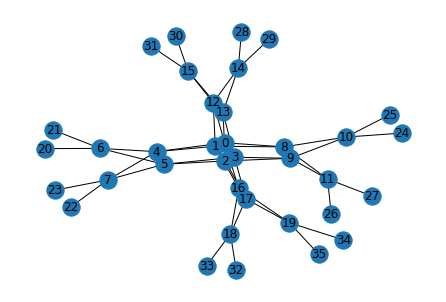

In [2]:
G = build_fattree(4)
nx.draw(G, with_labels=True)

In [3]:
df = pd.read_csv('../data/rsim.csv')

with open('../data/rsim.flow_to_port', 'rb') as f:
    flow_to_port = cloudpickle.load(f)
with open('../data/rsim.port_to_nexthop', 'rb') as f:
    port_to_nexthop = cloudpickle.load(f)

fid = 64
for d, ftp in flow_to_port.items():
    if 64 in ftp.keys():
        print(d, ftp[64])

3 3
5 3
7 1
17 1
19 3
23 0


In [4]:
# Get initial devices, and setup the initial packets to simulate.
initial_devices = pd.unique(df['cur_hub'].loc[df['path'].apply(lambda x: "-" not in x)])
devices = {d: Device(d, df.loc[df['cur_hub'] == d]) if d in initial_devices else Device(d, pd.DataFrame(columns=df.columns)) for d in pd.unique(df['cur_hub'])}

In [5]:
step = 0
model = None # TODO: Load the model here
while True:
    
    step += 1
    potential_updates = {d: dev.forward_block(None, port_to_nexthop, flow_to_port) for d, dev in devices.items()}
    made_update = False
    for d, (new_device_time, forward_dict) in potential_updates.items():
        # If there are packets to forward and the timestamp is not the places we are sending the packets to have timestamps of a certain kind.
        condition = forward_dict != {} # and ... TODO ...?
        if condition:
            made_update = True
            devices[d].update_time(new_device_time)
            for forward_device, new_packets in forward_dict.items():
                devices[forward_device].add_new_packets(new_packets)

    print(step, [devices[d].timestamp for d in range(20)])
    if not made_update:
        break

'c'